In [49]:
import numpy as np
import pandas as pd
import glob

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm
import numba

import bokeh
import bokeh.plotting
from bokeh.plotting import ColumnDataSource
from bokeh.models import LabelSet
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

In [50]:
#load each run into a separate dataframe
df1 = pd.read_csv('..\\190926_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df2 = pd.read_csv('..\\191007_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df3 = pd.read_csv('..\\191010_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df4 = pd.read_csv('..\\191015_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df5 = pd.read_csv('..\\191016_Outlier_Data.csv', comment='#')
df6 = pd.read_csv('..\\191020_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df7 = pd.read_csv('..\\191021_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df8 = pd.read_csv('..\\191022_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df9 = pd.read_csv('..\\191025_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df10 = pd.read_csv('..\\191027_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df11 = pd.read_csv('..\\191031_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df12 = pd.read_csv('..\\191106_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df13 = pd.read_csv('..\\191115_Deuterium_Transfer_Peak_Areas.csv', comment='#')
df14 = pd.read_csv('..\\191119_Deuterium_Transfer_Peak_Areas.csv', comment='#')

In [51]:
#add a column to each dataframe listing the date
df1['GCMS Date'] = '190926'
df2['GCMS Date'] = '191007'
df3['GCMS Date'] = '191010'
df4['GCMS Date'] = '191015'
df5['GCMS Date'] = '191016'
df6['GCMS Date'] = '191020'
df7['GCMS Date'] = '191021'
df8['GCMS Date'] = '191022'
df9['GCMS Date'] = '191025'
df10['GCMS Date'] = '191027'
df11['GCMS Date'] = '191031'
df12['GCMS Date'] = '191106'
df13['GCMS Date'] = '191115'
df14['GCMS Date'] = '191119'

#merge data frames into one dataframe
outlier_df=df1.append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9).append(df10).append(df11).append(df12).append(df13).append(df14)
outlier_df = outlier_df[['WellNumber','Outlier','GCMS Date']].drop_duplicates().astype(str)
outlier_df.head()

,WellNumber,Outlier,GCMS Date
0,1,N,190926
6,2,N,190926
12,3,BI,190926
18,4,BI,190926
24,5,N,190926


In [52]:
#Glob together all csvs with the deeplabcut generated position data. 
#The deeplabcut data lists the network iteration of the trained network at the end of the filename
#This value will always be a multiple of 1000
file_list=glob.glob('./*/*000.csv')
well_list=glob.glob('./*/*Well_Positions.csv')

#Date sync contains the dates that the video and GCMS data were collected on
#These two dates are different for every trial
date_sync = pd.read_csv('..\\DCHC_Date_sync.csv')

In [53]:
file_list[:3]

['.\\190919\\190919_DCHC_transfer_experiment_S_well_1DeepCut_resnet50_DCHC_transfer_analysis_20190919_SOct2shuffle1_80000.csv',
 '.\\190919\\190919_DCHC_transfer_experiment_S_well_2DeepCut_resnet50_DCHC_transfer_analysis_20190919_SOct2shuffle1_80000.csv',
 '.\\190919\\190919_DCHC_transfer_experiment_S_well_3DeepCut_resnet50_DCHC_transfer_analysis_20190919_SOct2shuffle1_80000.csv']

In [54]:
well_list[:2]

['.\\Well_positions\\190919_DCHC_transfer_experiment_S_Well_Positions.csv',
 '.\\Well_positions\\191003_DCHC_transfer_experiment_SP_Well_Positions.csv']

In [55]:
def circle_calc(x,y):
    #determine the equation of the circle circumscribing the central well of the arena using the three points marking the entrances to the antechamber
    #basing this off of Zaz's comment from https://math.stackexchange.com/questions/213658/get-the-equation-of-a-circle-when-given-3-points

    ones=np.ones(3)
    xy=(x**2 + y**2).values

    #creating the minors ofthe matrix of the system of equations
    M11=np.stack((x,y,ones),axis=1)
    M12=np.stack((xy,y,ones),axis=1)
    M13=np.stack((xy,x,ones),axis=1)
    M14=np.stack((xy,x,y),axis=1)

    #calculating the center of the circle as well as the radius
    x_0=1/2 * np.linalg.det(M12)/np.linalg.det(M11)
    y_0=-1/2 * np.linalg.det(M13)/np.linalg.det(M11)
    r=np.sqrt(x_0**2+y_0**2+(np.linalg.det(M14)/np.linalg.det(M11)))
    
    return x_0,y_0,r

In [103]:
#well_df contains the positions, in pixels, for each of the antechamber openings
#in each well from every video
for i,name in tqdm(enumerate(well_list)):
    #load each csv as a dataframe and append to the end of one large dataframe
    if i == 0:
        well_df=pd.read_csv(name,comment='#',usecols=['X','Y','WellNum','Date'])
    else:
        well_df=well_df.append(pd.read_csv(name,comment='#',usecols=['X','Y','WellNum','Date']))

14it [00:00, 226.17it/s]


In [104]:
well_df[['WellNum','Date']].drop_duplicates()

,WellNum,Date
0,1,190919
3,2,190919
6,3,190919
9,4,190919
12,5,190919
...,...,...
9,4,191115
12,5,191115
15,6,191115
18,7,191115


In [105]:
circle_df=well_df[['WellNum','Date']].drop_duplicates()
circle_df['x0']=0
circle_df['y0']=0
circle_df['r']=0
for i,row in well_df[['WellNum','Date']].drop_duplicates().iterrows():
    wellNum = row['WellNum']
    date = row['Date']
    
    x_0,y_0,r = circle_calc(well_df.loc[(well_df['WellNum'] == wellNum) & (well_df['Date'] == date),'X'],
                             well_df.loc[(well_df['WellNum'] == wellNum) & (well_df['Date'] == date),'Y'])
    circle_df.loc[(circle_df['WellNum'] == wellNum) & (circle_df['Date'] == date),'x0'] = x_0

    circle_df.loc[(circle_df['WellNum'] == wellNum) & (circle_df['Date'] == date),'y0'] = y_0
    
    circle_df.loc[(circle_df['WellNum'] == wellNum) & (circle_df['Date'] == date),'r'] = r

In [106]:
#number the three different well positions
well_df['Position'] = well_df.groupby(['Date','WellNum']).cumcount()+1

#convert integer well positions to str
well_df['Position']=well_df['Position'].astype(str)

#unstack data so that there is a multiindex with well position and xy position
well_df = well_df.set_index(['Date','WellNum','Position']).unstack()

#rename the column headings to mash together well position and x or y
well_df.columns=list(map("".join,well_df.columns))

well_df = well_df.reset_index()

well_df = well_df.rename(columns={'Date':'Video Date','WellNum':'WellNumber'})
well_df['Video Date']=well_df['Video Date'].astype(str)
well_df['WellNumber']=well_df['WellNumber'].astype(str)

In [108]:
circle_df=circle_df.rename(columns={'Date':'Video Date','WellNum':'WellNumber'})
circle_df['Video Date']=circle_df['Video Date'].astype(str)
circle_df['WellNumber']=circle_df['WellNumber'].astype(str)
well_df=well_df.merge(circle_df)

In [109]:
well_df.head(2)

,Video Date,WellNumber,X1,X2,X3,Y1,Y2,Y3,x0,y0,r
0,190919,1,533,368,215,271,551,275,375.177529,366.613544,184.526102
1,190919,2,530,367,208,272,551,271,368.709987,364.884329,186.123526


In [61]:
#create dataframe for movement data as well as metadata
df = pd.DataFrame()

for name in tqdm(file_list):
    df_intermediate = pd.read_csv(name,header=[1,2])
    
    #collapse hierarchical column names into one level, separating upper and lower level
    #by a space
    df_intermediate.columns=list(map(" ".join, df_intermediate.columns))
    
    #pull metadata out of filename and add to dataframe
    df_intermediate['species'] = name[name.rfind('_',0,name.rfind('_'))+1]
    df_intermediate['Video Date'] = name[name.find('\\')+1:name.find('\\')+7]
    df_intermediate['WellNumber'] = name[name.find('well')+5:name.find('well')+6]
    df_intermediate['file path'] = name
    
    df = df.append(df_intermediate, ignore_index=True,sort=True)

df['length upper'] = ''

100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [02:03<00:00,  1.14s/it]


In [62]:
#create a new column named antlength
#antlength is the length of the ant calculated from the head and gaster position data
df['antlength'] = np.sqrt((df['anthead x'] - df['antgaster x'])**2 + 
                          (df['anthead y'] - df['antgaster y'])**2)

In [63]:
#list all dates in the metadata file
np.unique(df['Video Date'])

array(['190919', '191003', '191008', '191012', '191016', '191019',
       '191020', '191021', '191022', '191025', '191029', '191105',
       '191113', '191115'], dtype=object)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.61s/it]


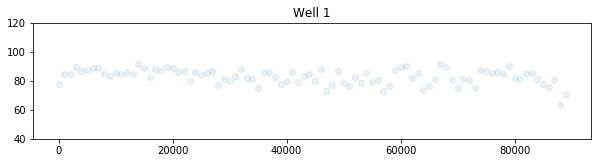

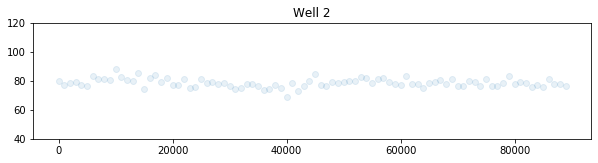

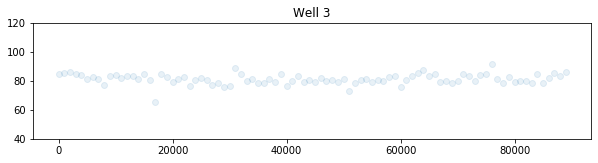

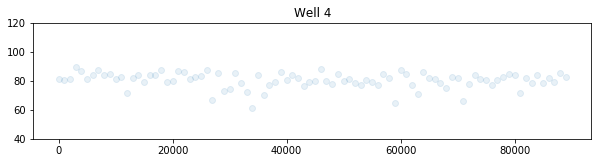

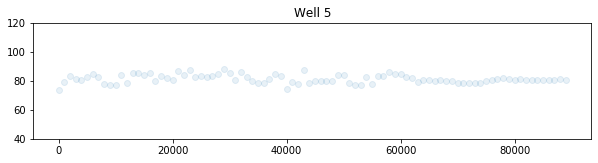

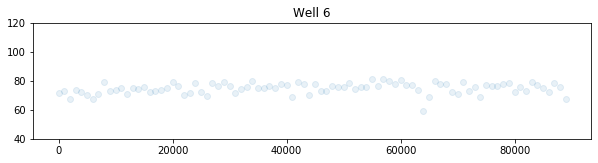

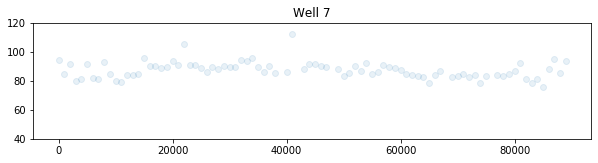

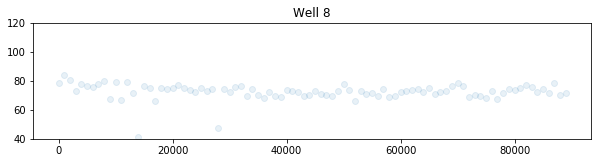

In [74]:
#count is used to specify the position of each subplot
count=0

#date specifies the date of the data collection to be analyzed
date='191105'

#loop through the indices of the rows from the ID dataframe. These indices should match
#up with the position of the corresponding dataframe in the dataframe list.
for i in tqdm(df['WellNumber'].loc[df['Video Date']==date].unique()):
    subplt = int(str(len(df['WellNumber'].loc[df['Video Date']==date].unique())) + '1' + str(count+1))
    plt.figure(figsize=(10,20))
    plt.subplot(subplt)
    plt.title('Well ' + i)
    plt.scatter(df.loc[(df['Video Date']==date) & (df['WellNumber'] == i)]['bodyparts coords'][::1000],\
                df.loc[(df['Video Date']==date) & (df['WellNumber'] == i)]['antlength'][::1000],alpha=0.1)
    plt.ylim([40,120])
    count = count+1

In [75]:
df.loc[df['Video Date']=='190919','length upper'] = 120
df.loc[df['Video Date']=='191003','length upper'] = 120
df.loc[df['Video Date']=='191008','length upper'] = 110
df.loc[df['Video Date']=='191012','length upper'] = 110
df.loc[df['Video Date']=='191016','length upper'] = 110
df.loc[df['Video Date']=='191019','length upper'] = 110
df.loc[df['Video Date']=='191020','length upper'] = 110
df.loc[df['Video Date']=='191021','length upper'] = 110
df.loc[df['Video Date']=='191022','length upper'] = 110
df.loc[df['Video Date']=='191025','length upper'] = 110
df.loc[df['Video Date']=='191029','length upper'] = 125
df.loc[df['Video Date']=='191105','length upper'] = 120
df.loc[df['Video Date']=='191113','length upper'] = 110
df.loc[df['Video Date']=='191115','length upper'] = 120

In [76]:
df = pd.merge(df,date_sync.astype(str),left_on='Video Date',right_on='Video Date')

In [77]:
df = pd.merge(df,outlier_df)

In [78]:
df.head()

,Video Date,WellNumber,antgaster likelihood,antgaster x,antgaster y,anthead likelihood,anthead x,anthead y,beetleabdomen likelihood,beetleabdomen x,...,file path,species,length upper,antlength,GCMS Date_x,Outlier,good frames,avglen,GCMS Date_y,GCMS Date
0,190919,1,0.999999,361.601315,394.884507,1.0,427.767942,399.401206,NaN,NaN,...,.\190919\190919_DCHC_transfer_experiment_S_wel...,S,120,66.320608,190926,N,True,68.442639,190926,190926
1,190919,1,0.999999,361.601315,394.884507,1.0,427.767942,399.401206,NaN,NaN,...,.\190919\190919_DCHC_transfer_experiment_S_wel...,S,120,66.320608,190926,N,True,68.442639,190926,191010
2,190919,1,0.999999,361.601315,394.884507,1.0,427.767942,399.401206,NaN,NaN,...,.\190919\190919_DCHC_transfer_experiment_S_wel...,S,120,66.320608,190926,N,True,68.442639,190926,191015
3,190919,1,0.999999,361.601315,394.884507,1.0,427.767942,399.401206,NaN,NaN,...,.\190919\190919_DCHC_transfer_experiment_S_wel...,S,120,66.320608,190926,N,True,68.442639,190926,191020
4,190919,1,0.999999,361.601315,394.884507,1.0,427.767942,399.401206,NaN,NaN,...,.\190919\190919_DCHC_transfer_experiment_S_wel...,S,120,66.320608,190926,N,True,68.442639,190926,191022


In [79]:
#Remove outlier datapoints, i.e.: 
#'Y' ant or beetle crushed
#'BI' beetle injured
#'AI' ant injured (prior to introduction to arena)
df = df.loc[(df['Outlier']!='Y') | (df['Outlier']!='BI') | (df['Outlier']=='AI')]

In [80]:
df['good frames'] = df['antlength'] < df['length upper']

In [81]:
#Compute the average ant length from the good frames in each
#well from each date
avgLen = df[['antlength','Video Date','WellNumber']].loc[df['good frames']].groupby(['Video Date','WellNumber']).mean()

In [82]:
#Merge the average ant length from each well back into the main dataframe
df = df.merge(avgLen.reset_index().rename(columns={'antlength':'avglen'}))

In [83]:
df.tail()

,Video Date,WellNumber,antgaster likelihood,antgaster x,antgaster y,anthead likelihood,anthead x,anthead y,beetleabdomen likelihood,beetleabdomen x,...,file path,species,length upper,antlength,GCMS Date_x,Outlier,good frames,avglen,GCMS Date_y,GCMS Date
1264015,191105,7,0.999983,562.718793,124.220759,0.999996,495.179371,64.507696,NaN,NaN,...,.\191105\191105_DCHC_transfer_experiment_D_wel...,D,120,90.151114,191106,B,True,85.851185,191106,191106
1264016,191105,7,0.999998,503.045364,109.823997,0.999996,513.904286,46.906156,NaN,NaN,...,.\191105\191105_DCHC_transfer_experiment_D_wel...,D,120,63.848030,191106,B,True,85.851185,191106,191106
1264017,191105,7,0.999980,540.204365,109.650765,0.999990,622.786471,122.781849,NaN,NaN,...,.\191105\191105_DCHC_transfer_experiment_D_wel...,D,120,83.619553,191106,B,True,85.851185,191106,191106
1264018,191105,7,0.999990,539.589619,142.376575,0.999998,558.365531,73.222935,NaN,NaN,...,.\191105\191105_DCHC_transfer_experiment_D_wel...,D,120,71.657246,191106,B,True,85.851185,191106,191106
1264019,191105,7,0.999965,474.765394,40.650566,1.000000,532.429595,100.290112,NaN,NaN,...,.\191105\191105_DCHC_transfer_experiment_D_wel...,D,120,82.958034,191106,B,True,85.851185,191106,191106


## Touching metric
The metric for touching is if the head of the beetle (or tip of abdomen as well in the case of Platyusa) is within the bounds of an ellipse drawn around the ant. In the case that the length of the ant is above the upper bound specified above (i.e. good frames == False in practice this either corresponds to a mislabeling by deeplabcut or more likely the ant has been bitten in half by a platyusa) then the ant and beetle are touching if either the head or tip of abdomen of the beetle are within 1 body length of either ant part.

In [84]:
#calculating the distance between the head of the beetle and the head of the ant
df['head2head'] = np.sqrt((df['beetlehead x'] - df['anthead x'])**2 +
                          (df['beetlehead y'] - df['anthead y'])**2)
#calculating the distance between the head of the beetle and the gaster of the ant
df['head2butt'] = np.sqrt((df['beetlehead x'] - df['antgaster x'])**2 +
                          (df['beetlehead y'] - df['antgaster y'])**2)

I am going to use a trick in the following code block that is most likely a fairly poor programming practice. I have position data for the beetleabdomen of 
Platyusa but not for the abdomen of Sceptobius and Dalotia. The entries in the beetleabdomen column are nan for Sceptobius and Dalotia, so if I calculate distances for Platyusa (using both the head and the abdomen) the nans should cause the abdomen calculations to not be used, simplifying down to the case of the head distances.

In [85]:
#calculating the distance between the abdomen tip of the beetle and the head of the ant
#this column will have nans for sceptobius and dalotia
df['butt2head'] = np.sqrt((df['beetleabdomen x'] - df['anthead x'])**2 +
                          (df['beetleabdomen y'] - df['anthead y'])**2)

#calculating the distance between the abdomen tip of the beetle and the gaster of the ant
#this column will have nans for Sceptobius and Dalotia
df['butt2butt'] = np.sqrt((df['beetleabdomen x'] - df['antgaster x'])**2 +
                          (df['beetleabdomen y'] - df['antgaster y'])**2)

In [86]:
#calcate the combined distance of the beetle head to the ant head and ant gaster
df['ellipse distance'] = df['head2head'] + df['head2butt']

#calculate the combined distance of the beetle abdomen to the ant head and ant gaster
#this collumn will have nans for Sceptobius and Dalotia
df['butt ellipse distance'] = df['butt2head'] + df['butt2butt']

#calculate the lesser of the head ellipse distance and abdomen ellipse distance
#if the abdomen ellipse distance is less, set those rows of ellipse distance 
#equal to the abdomen ellipse distance
df.loc[df['butt ellipse distance'] > df['ellipse distance'],'ellipse distance'] = \
    df.loc[df['butt ellipse distance'] > df['ellipse distance'],'butt ellipse distance']

In [87]:
#If ellipse distance is less than 1.4 times the length of the ant, the ant and beetle are touching
#so long as the frames are good frames. For the frames that are not good, the ant and beetle are 
#touching if any of the distances between the ant or beetle head or abdomen are less than the 
#average length of the ant.
df['touching'] = ((df['antlength']*1.4 > df['ellipse distance'])&df['good frames']) | \
                     ((~df['good frames']) & \
                      ((df['head2head']<df['avglen']) | (df['head2butt']<df['avglen']) | \
                       (df['butt2head']<df['avglen']) | (df['butt2butt']<df['avglen'])))

In [88]:
df.tail()

,Video Date,WellNumber,antgaster likelihood,antgaster x,antgaster y,anthead likelihood,anthead x,anthead y,beetleabdomen likelihood,beetleabdomen x,...,avglen,GCMS Date_y,GCMS Date,head2head,head2butt,butt2head,butt2butt,ellipse distance,butt ellipse distance,touching
1264015,191105,7,0.999983,562.718793,124.220759,0.999996,495.179371,64.507696,NaN,NaN,...,85.851185,191106,191106,440.788868,364.426188,NaN,NaN,805.215056,NaN,False
1264016,191105,7,0.999998,503.045364,109.823997,0.999996,513.904286,46.906156,NaN,NaN,...,85.851185,191106,191106,451.738439,395.615808,NaN,NaN,847.354247,NaN,False
1264017,191105,7,0.999980,540.204365,109.650765,0.999990,622.786471,122.781849,NaN,NaN,...,85.851185,191106,191106,357.850610,384.551821,NaN,NaN,742.402430,NaN,False
1264018,191105,7,0.999990,539.589619,142.376575,0.999998,558.365531,73.222935,NaN,NaN,...,85.851185,191106,191106,415.631312,353.304220,NaN,NaN,768.935533,NaN,False
1264019,191105,7,0.999965,474.765394,40.650566,1.000000,532.429595,100.290112,NaN,NaN,...,85.851185,191106,191106,395.112763,470.155381,NaN,NaN,865.268144,NaN,False


## The behavioral arena that I used is not completely open but instead constists of a central chamber surrounded by three antechambers.
The distance from any one point in the arena to any other point thne can thus be expressed in two ways. I already calculated the euclidean distance between various parts of the ant and various parts of the beetle. A second way to calculate the distance would be to consider the distance that one of the insects would have to walk to get to the other insect.

In [115]:
#Merge antechamber opening positions into the main dataframe
df = df.merge(well_df)

#determine the distance between a label and the three antechamber entrance locations
df['ant dist1']=np.sqrt((df['anthead x']-df['X1'])**2 + (df['anthead y']-df['Y1'])**2)
df['ant dist2']=np.sqrt((df['anthead x']-df['X2'])**2 + (df['anthead y']-df['Y2'])**2)
df['ant dist3']=np.sqrt((df['anthead x']-df['X3'])**2 + (df['anthead y']-df['Y3'])**2)

df['beetle dist1']=np.sqrt((df['beetlehead x']-df['X1'])**2 + (df['beetlehead y']-df['Y1'])**2)
df['beetle dist2']=np.sqrt((df['beetlehead x']-df['X2'])**2 + (df['beetlehead y']-df['Y2'])**2)
df['beetle dist3']=np.sqrt((df['beetlehead x']-df['X3'])**2 + (df['beetlehead y']-df['Y3'])**2)

#determine which of the three antechamber entrances is closest to the given point
df['ant closest']=0*((df['ant dist1']<df['ant dist2'])&(df['ant dist1']<df['ant dist3'])) + \
                  1*((df['ant dist2']<df['ant dist1'])&(df['ant dist2']<df['ant dist3'])) + \
                  2*((df['ant dist3']<df['ant dist1'])&(df['ant dist3']<df['ant dist2']))

df['beetle closest']=0*((df['beetle dist1']<df['beetle dist2'])&(df['beetle dist1']<df['beetle dist3'])) + \
                     1*((df['beetle dist2']<df['beetle dist1'])&(df['beetle dist2']<df['beetle dist3'])) + \
                     2*((df['beetle dist3']<df['beetle dist1'])&(df['beetle dist3']<df['beetle dist2']))

In [116]:
df=df.merge(well_df)

In [117]:
df.head(2)

,Video Date,WellNumber,antgaster likelihood,antgaster x,antgaster y,anthead likelihood,anthead x,anthead y,beetleabdomen likelihood,beetleabdomen x,...,y0,r,ant dist1,ant dist2,ant dist3,beetle dist1,beetle dist2,beetle dist3,ant closest,beetle closest
0,190919,4,1.0,361.332284,333.551152,1.000000,383.571879,281.759534,NaN,NaN,...,360.282285,184.719654,143.909390,263.894785,177.273775,107.979783,333.834491,415.923729,0,0
1,190919,4,1.0,361.127532,333.275976,0.999999,382.429988,281.971701,NaN,NaN,...,360.282285,184.719654,145.064847,263.605180,176.155545,164.233487,331.718674,458.010040,0,0


In [126]:
df[['ant dist1','ant dist2','ant dist3']].head().values

177.27377509808844

In [131]:
#determine if the ant and the beetle are inside or outside of the circle
#plug in the position of the beetle into the left side of (x_0-x)**2 + (y_0-y)**2 < r**2
#and determine if the value is smaller than than the right side
df['ant in circle'] = np.sqrt((df['anthead x']-x_0)**2 + (df['anthead y']-y_0)**2) < r
df['beetle in circle'] = np.sqrt((df['beetlehead x']-x_0)**2 + (df['beetlehead y']-y_0)**2) < r

#creating columns for the location of the beetle and ant. If the beetle is in the center of the circle,
#the location coding is 3, otherwise it is 0-3 starting in the bottom right chamber working counterclockwise
df['ant loc'] = 3*df['ant in circle'] + (df['ant closest'] & ~df['ant in circle'])
df['beetle loc'] = 3*df['beetle in circle'] + (df['beetle closest'] & ~df['beetle in circle'])

#determining all of the possible distances that need to be measured
#euclidean distance between the ant and the beetle
euclidean_dist=df['head2head']

#distance from the beetle to the nearest antechamber entrance
beetle2beetleentrance=np.sqrt(np.min(df[['beetle dist1','beetle dist2','beetle dist3']],axis=1))

#distance from the beetle to the antechamber entrance nearest the ant
beetle2antentrance=df['beetle dist1'].loc[(df['ant dist1']<df['ant dist2'])&(df['ant dist1']<df['ant dist3'])] + \
                   df['beetle dist2'].loc[(df['ant dist2']<df['ant dist1'])&(df['ant dist2']<df['ant dist3'])] + \
                   df['beetle dist2'].loc[(df['ant dist3']<df['ant dist1'])&(df['ant dist3']<df['ant dist2'])]

#distance from the ant to the nearest antechamber entrance
ant2antentrance=np.sqrt(np.min(df[['ant dist1','ant dist2','ant dist3']],axis=1))

#distance from the ant to the antechamber entrance nearest the beetle
ant2beetleentrance=df['ant dist1'].loc[(df['beetle dist1']<df['beetle dist2'])&(df['beetle dist1']<df['beetle dist3'])] + \
                   df['ant dist2'].loc[(df['beetle dist2']<df['beetle dist1'])&(df['beetle dist2']<df['beetle dist3'])] + \
                   df['ant dist2'].loc[(df['beetle dist3']<df['beetle dist1'])&(df['beetle dist3']<df['beetle dist2'])]

#distance between the two antechamber entrances
entrance2entrance=0+ \
                  np.sqrt((df['X1']-df['X2'])**2 + (df['Y1']-df['Y2'])**2).loc(
                          (df['ant closest']==1 & df['beetle closest']==2) | \
                          (df['ant closest']==2 & df['beetle closest']==1))+ \
                  np.sqrt((df['X1']-df['X3'])**2 + (df['Y1']-df['Y3'])**2).loc(
                          (df['ant closest']==1 & df['beetle closest']==3) | \
                          (df['ant closest']==3 & df['beetle closest']==1))+ \
                  np.sqrt((df['X3']-df['X2'])**2 + (df['Y3']-df['Y2'])**2).loc(
                          (df['ant closest']==3 & df['beetle closest']==2) | \
                          (df['ant closest']==2 & df['beetle closest']==3))

df['actual distance'] = (df['ant loc']==df['beetle loc'])*euclidean_dist + \
                         (df['ant loc']!=df['beetle loc'])* \
                         ((df['ant loc']==3)*(ant2beetleentrance+beetle2beetleentrance) + \
                          (df['beetle loc']==3)*(beetle2antentrance+ant2antentrance) + \
                          ((df['ant loc']!=3)*(df['beetle loc']!=3))* \
                           (ant2antentrance+beetle2beetleentrance+entrance2entrance))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

,Video Date,WellNumber,antgaster likelihood,antgaster x,antgaster y,anthead likelihood,anthead x,anthead y,beetleabdomen likelihood,beetleabdomen x,...,ellipse distance,butt ellipse distance,touching,WellNum,X1,X2,X3,Y1,Y2,Y3
0,190919,1,0.999999,361.601315,394.884507,1.0,427.767942,399.401206,NaN,NaN,...,654.039905,NaN,False,1,533,368,215,271,551,275
1,190919,1,0.999999,361.601315,394.884507,1.0,427.767942,399.401206,NaN,NaN,...,654.039905,NaN,False,2,530,367,208,272,551,271
2,190919,1,0.999999,361.601315,394.884507,1.0,427.767942,399.401206,NaN,NaN,...,654.039905,NaN,False,3,521,364,200,278,551,273
3,190919,1,0.999999,361.601315,394.884507,1.0,427.767942,399.401206,NaN,NaN,...,654.039905,NaN,False,4,527,365,207,270,545,266
4,190919,1,0.999999,361.601315,394.884507,1.0,427.767942,399.401206,NaN,NaN,...,654.039905,NaN,False,5,524,361,199,275,555,275


In [104]:
#create dataframe for metadata\
#data index keeps track of index in df_list so that any reordering of 
#metadata during datafram merges doesn't mess up indexing 
metadata=pd.DataFrame(columns=['WellNumber','species','Video Date','file path','data index'])
#list to contain all position dataframes

for i,name in tqdm(enumerate(file_list)):
    #load each csv as a dataframe into a list
    df_list.update({str(i) : pd.read_csv(name,header=[1,2])})
    
    #pull metadata out of the filenames (Species identifier, collection date, well number)
    metadata = metadata.append({'species':name[name.rfind('_',0,name.rfind('_'))+1], 
                        'Video Date':name[name.find('\\')+1:name.find('\\')+7],
                        'WellNumber':name[name.find('well')+5:name.find('well')+6],
                        'file path' : name,
                        'data index' : i},
                     ignore_index=True)

#creating columns for the ant length information
metadata['length lower']=''
metadata['length upper']=''

TypeError: __init__() got an unexpected keyword argument 'name'

In [11]:
#loop through the each dataframe and create a new column named antlength
#antlength is the length of the ant calculated from the head and gaster position data
for df in tqdm(df_list.values()):
    df['antlength'] = np.sqrt((df['anthead']['x'] - df['antgaster']['x'])**2 + 
                           (df['anthead']['y'] - df['antgaster']['y'])**2)

100%|███████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 111.11it/s]


In [12]:
#list all dates in the metadata file
np.unique(metadata['Video Date'])

array(['190919', '191003', '191008', '191012', '191016', '191019',
       '191020', '191021', '191022', '191025', '191029', '191105',
       '191113', '191115'], dtype=object)

### In the next section the ant lengths from each experiment are plotted in order to determine an upper and lower bound for the length of the ant in each well

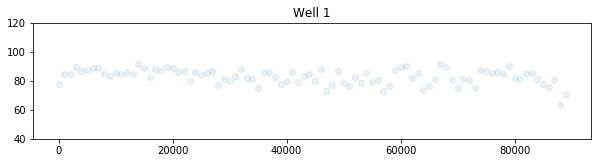

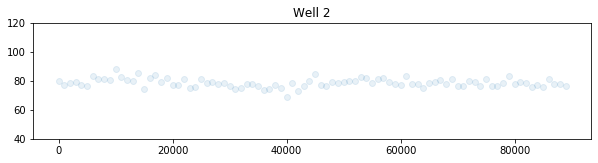

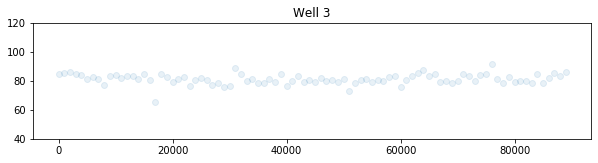

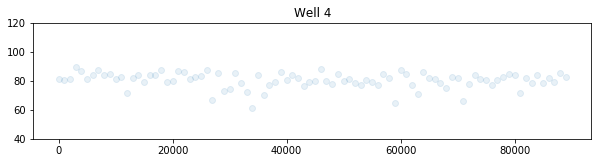

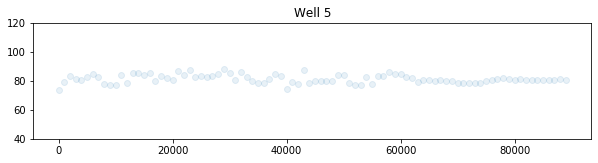

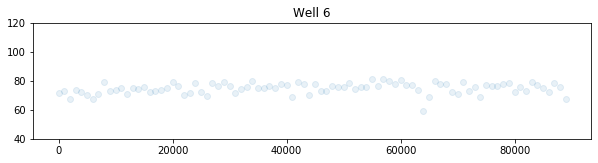

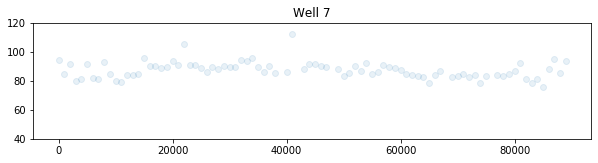

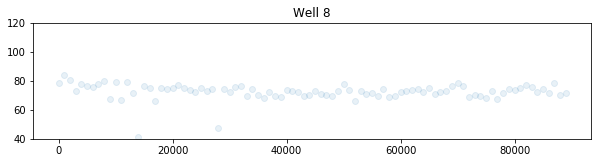

In [13]:
#count is used to specify the position of each subplot
count=0

#date specifies the date of the data collection to be analyzed
date='191105'

#loop through the indices of the rows from the ID dataframe. These indices should match
#up with the position of the corresponding dataframe in the dataframe list.
for i in metadata.loc[metadata['Video Date']==date].index:
    df=df_list[str(i)]
    subplt = int(str(len(metadata.loc[metadata['Video Date']==date].index)) + '1' + str(count+1))
    plt.figure(figsize=(10,20))
    plt.subplot(subplt)
    plt.title('Well ' + metadata.iloc[i]['WellNumber'])
    plt.scatter(df['bodyparts']['coords'][::1000],df['antlength'][::1000],alpha=0.1)
    plt.ylim([40,120])
    count = count+1

# Thought
Maybe don't need to have a lower bound. Isn't too big of an issue if either head or gaster is incorrectly labelled so long as it is closer to the other marker than what it should be

In [14]:
#metadata['length lower'].loc[metadata['Video Date']=='190919'] = 40
metadata['length upper'].loc[metadata['Video Date']=='190919'] = 120
#metadata['length lower'].loc[metadata['Video Date']=='191003'] = 40
metadata['length upper'].loc[metadata['Video Date']=='191003'] = 120
#metadata['length lower'].loc[metadata['Video Date']=='191008'] = 30
metadata['length upper'].loc[metadata['Video Date']=='191008'] = 110
#metadata['length lower'].loc[metadata['Video Date']=='191012'] = 30
metadata['length upper'].loc[metadata['Video Date']=='191012'] = 110
#metadata['length lower'].loc[metadata['Video Date']=='191016'] = 30
metadata['length upper'].loc[metadata['Video Date']=='191016'] = 110
#metadata['length lower'].loc[metadata['Video Date']=='191019'] = 30
metadata['length upper'].loc[metadata['Video Date']=='191019'] = 110
#metadata['length lower'].loc[metadata['Video Date']=='191020'] = 30
metadata['length upper'].loc[metadata['Video Date']=='191020'] = 110
#metadata['length lower'].loc[metadata['Video Date']=='191021'] = 30
metadata['length upper'].loc[metadata['Video Date']=='191021'] = 110
#metadata['length lower'].loc[metadata['Video Date']=='191022'] = 30
metadata['length upper'].loc[metadata['Video Date']=='191022'] = 110
#metadata['length lower'].loc[metadata['Video Date']=='191025'] = 30
metadata['length upper'].loc[metadata['Video Date']=='191025'] = 110
#metadata['length lower'].loc[metadata['Video Date']=='191029'] = 45
metadata['length upper'].loc[metadata['Video Date']=='191029'] = 125
#metadata['length lower'].loc[metadata['Video Date']=='191105'] = 40
metadata['length upper'].loc[metadata['Video Date']=='191105'] = 120
#metadata['length lower'].loc[metadata['Video Date']=='191113'] = 30
metadata['length upper'].loc[metadata['Video Date']=='191113'] = 110
#metadata['length lower'].loc[metadata['Video Date']=='191115'] = 40
metadata['length upper'].loc[metadata['Video Date']=='191115'] = 120

In [15]:
metadata.head()

,WellNumber,species,Video Date,file path,data index,length lower,length upper
0,1,S,190919,.\190919\190919_DCHC_transfer_experiment_S_wel...,0,,120
1,2,S,190919,.\190919\190919_DCHC_transfer_experiment_S_wel...,1,,120
2,3,S,190919,.\190919\190919_DCHC_transfer_experiment_S_wel...,2,,120
3,4,S,190919,.\190919\190919_DCHC_transfer_experiment_S_wel...,3,,120
4,5,S,190919,.\190919\190919_DCHC_transfer_experiment_S_wel...,4,,120


In [16]:
date_sync.head()

,Video Date,GCMS Date
0,190919,190926
1,191003,191007
2,191008,191010
3,191012,191015
4,191016,191016


In [17]:
outlier_df.head(2)

,WellNumber,Outlier,GCMS Date
0,1,N,190926
6,2,N,190926


In [18]:
date_sync = date_sync.astype(str).merge(outlier_df)
metadata = metadata.merge(date_sync)

In [113]:
metadata.tail()

,WellNumber,species,Video Date,file path,data index,length lower,length upper,GCMS Date,Outlier
104,4,D,191115,.\191115\191115_DCHC_transfer_experiment_D_wel...,104,,120,191119,N
105,5,D,191115,.\191115\191115_DCHC_transfer_experiment_D_wel...,105,,120,191119,N
106,6,D,191115,.\191115\191115_DCHC_transfer_experiment_D_wel...,106,,120,191119,N
107,7,D,191115,.\191115\191115_DCHC_transfer_experiment_D_wel...,107,,120,191119,N
108,8,D,191115,.\191115\191115_DCHC_transfer_experiment_D_wel...,108,,120,191119,N


In [21]:
outliers = metadata.loc[(metadata['Outlier']=='Y') | (metadata['Outlier']=='BI')| (metadata['Outlier']=='AI')].index
metadata = metadata.loc[(metadata['Outlier']!='Y') | (metadata['Outlier']!='BI')| (metadata['Outlier']=='AI')]

In [20]:
for outindex in outliers:
    df_list.pop(str(outindex))

In [22]:
for index,df in df_list.items():
    df['good frames'] = (df['antlength'] < metadata['length upper'].iloc[int(index)])

In [68]:
for index,df in df_list.items():
    avgLen = np.average(df['antlength'].loc[df['good frames']])
    df['touching'] = False

    df['head2head'] = np.sqrt((df['beetlehead']['x'] - df['anthead']['x'])**2 + 
                              (df['beetlehead']['y'] - df['anthead']['y'])**2)
        
    df['head2butt'] = np.sqrt((df['beetlehead']['x'] - df['antgaster']['x'])**2 + 
                              (df['beetlehead']['y'] - df['antgaster']['y'])**2)
    
    if ((metadata['species'].iloc[int(index)] == 'S') | (metadata['species'].iloc[int(index)] == 'D'))[0]:
        df['ellipse distance'] = df['head2head'] + df['head2butt']
        df['touching'] = ((df['antlength']*1.4 > df['ellipse distance'])&df['good frames']) | ((df['head2head']<avgLen) | (df['head2butt']<avgLen))
        
    if (metadata.loc[metadata['data index'] == int(index),'species'] == 'P')[0]:
        df['butt2head'] = np.sqrt((df['beetleabdomen']['x'] - df['anthead']['x'])**2 + 
                              (df['beetleabdomen']['y'] - df['anthead']['y'])**2)
        
        df['butt2butt'] = np.sqrt((df['beetleabdomen']['x'] - df['antgaster']['x'])**2 + 
                              (df['beetleabdomen']['y'] - df['antgaster']['y'])**2)
    
        headEllipse=df['head2head'] + df['head2butt']
        buttEllipse=df['butt2head'] + df['butt2butt']
    
        df['ellipse distance'] = headEllipse*(headEllipse<buttEllipse) + buttEllipse*(buttEllipse<headEllipse)
    
        df['touching'] = ((df['antlength']*1.4 > df['ellipse distance'])&df['good frames']) \
                            | ((df['head2head']<avgLen) | (df['head2butt']<avgLen))\
                            | ((df['butt2head']<avgLen) | (df['butt2butt']<avgLen))

KeyError: 0

In [ ]:
sum(df_list[1]['touching'])

In [ ]:
metadata['touching percent']=''
for i,df in enumerate(df_list):
    metadata['touching percent'].iloc[i] = (sum(df['touching'])/len(df))

In [ ]:
plt.scatter(metadata['species'],metadata['touching percent'],alpha=0.7)

In [ ]:
metadata.head()

In [ ]:
metadata.to_csv(path_or_buf='.\Movement_metadata.csv')

In [ ]:
well_df.head()

In [ ]:
for i,df in enumerate(df_list):
    positions=well_df.loc[(well_df['Date'] == int(metadata['Video Date'].iloc[i]))&(well_df['WellNum'] == int(metadata['WellNumber'].iloc[i]))]
    positions = positions.append(positions.iloc[2]*0,ignore_index=True)
    #determine the distance between a label and the three antechamber entrance locations
    df['ant dist1']=np.sqrt((df['anthead']['x']-positions.iloc[0]['X'])**2 + (df['anthead']['y']-positions.iloc[0]['Y'])**2)
    df['ant dist2']=np.sqrt((df['anthead']['x']-positions.iloc[1]['X'])**2 + (df['anthead']['y']-positions.iloc[1]['Y'])**2)
    df['ant dist3']=np.sqrt((df['anthead']['x']-positions.iloc[2]['X'])**2 + (df['anthead']['y']-positions.iloc[2]['Y'])**2)

    df['beetle dist1']=np.sqrt((df['beetlehead']['x']-positions.iloc[0]['X'])**2 + (df['beetlehead']['y']-positions.iloc[0]['Y'])**2)
    df['beetle dist2']=np.sqrt((df['beetlehead']['x']-positions.iloc[1]['X'])**2 + (df['beetlehead']['y']-positions.iloc[1]['Y'])**2)
    df['beetle dist3']=np.sqrt((df['beetlehead']['x']-positions.iloc[2]['X'])**2 + (df['beetlehead']['y']-positions.iloc[2]['Y'])**2)

    #determine which of the three antechamber entrances is closest to the given point
    df['ant closest']=0*((df['ant dist1']<df['ant dist2'])&(df['ant dist1']<df['ant dist3'])) + \
                       1*((df['ant dist2']<df['ant dist1'])&(df['ant dist2']<df['ant dist3'])) + \
                       2*((df['ant dist3']<df['ant dist1'])&(df['ant dist3']<df['ant dist2']))

    df['beetle closest']=0*((df['beetle dist1']<df['beetle dist2'])&(df['beetle dist1']<df['beetle dist3'])) + \
                       1*((df['beetle dist2']<df['beetle dist1'])&(df['beetle dist2']<df['beetle dist3'])) + \
                       2*((df['beetle dist3']<df['beetle dist1'])&(df['beetle dist3']<df['beetle dist2']))

    #determine the equation of the circle circumscribing the central well of the arena using the three points marking the entrances to the antechamber
    #basing this off of Zaz's comment from https://math.stackexchange.com/questions/213658/get-the-equation-of-a-circle-when-given-3-points
    x=positions['X'][:3].values
    y=positions['Y'][:3].values
    ones=np.ones(3)
    xy=(positions['X'][:3]**2 + positions['Y'][:3]**2).values

    #creating the minors ofthe matrix of the system of equations
    M11=np.stack((x,y,ones),axis=1)
    M12=np.stack((xy,y,ones),axis=1)
    M13=np.stack((xy,x,ones),axis=1)
    M14=np.stack((xy,x,y),axis=1)

    #calculating the center of the circle as well as the radius
    x_0=1/2 * np.linalg.det(M12)/np.linalg.det(M11)
    y_0=-1/2 * np.linalg.det(M13)/np.linalg.det(M11)
    r=np.sqrt(x_0**2+y_0**2+(np.linalg.det(M14)/np.linalg.det(M11)))

    #determine if the ant and the beetle are inside or outside of the circle
    #plug in the position of the beetle into the left side of (x_0-x)**2 + (y_0-y)**2 < r**2
    #and determine if the value is smaller than than the right side
    df['ant in circle'] = np.sqrt((df['anthead']['x']-x_0)**2 + (df['anthead']['y']-y_0)**2) < r
    df['beetle in circle'] = np.sqrt((df['beetlehead']['x']-x_0)**2 + (df['beetlehead']['y']-y_0)**2) < r

    #creating columns for the location of the beetle and ant. If the beetle is in the center of the circle,
    #the location coding is 3, otherwise it is 0-3 starting in the bottom right chamber working counterclockwise
    df['ant loc'] = 3*df['ant in circle'] + (df['ant closest'] & ~df['ant in circle'])
    df['beetle loc'] = 3*df['beetle in circle'] + (df['beetle closest'] & ~df['beetle in circle'])
    
    #determining all of the possible distances that need to be measured
    #euclidean distance between the ant and the beetle
    euclidean_dist=df['head2head']

    #distance from the beetle to the nearest antechamber entrance
    beetle2beetleentrance=np.sqrt((df['beetlehead']['x']-positions['X'].iloc[df['beetle closest']].values)**2 + \
                                  (df['beetlehead']['y']-positions['Y'].iloc[df['beetle closest']].values)**2)

    #distance from the beetle to the antechamber entrance nearest the ant
    beetle2antentrance=np.sqrt((df['beetlehead']['x']-positions['X'].iloc[df['ant closest']].values)**2 + \
                               (df['beetlehead']['y']-positions['Y'].iloc[df['ant closest']].values)**2)

    #distance from the ant to the nearest antechamber entrance
    ant2antentrance=np.sqrt((df['anthead']['x']-positions['X'].iloc[df['ant closest']].values)**2 + \
                            (df['anthead']['y']-positions['Y'].iloc[df['ant closest']].values)**2)

    #distance from the ant to the antechamber entrance nearest the beetle
    ant2beetleentrance=np.sqrt((df['anthead']['x']-positions['X'].iloc[df['beetle closest']].values)**2 + \
                               (df['anthead']['y']-positions['Y'].iloc[df['beetle closest']].values)**2)

    #distance between the two antechamber entrances
    entrance2entrance=np.sqrt((positions['X'].iloc[df['ant closest']].values-positions['X'].iloc[df['beetle closest']].values)**2 + \
                              (positions['Y'].iloc[df['ant closest']].values-positions['Y'].iloc[df['beetle closest']].values)**2)
    
    df['actual distance'] = (df['ant loc']==df['beetle loc'])*euclidean_dist + \
                             (df['ant loc']!=df['beetle loc'])* \
                             ((df['ant loc']==3)*(ant2beetleentrance+beetle2beetleentrance) + \
                              (df['beetle loc']==3)*(beetle2antentrance+ant2antentrance) + \
                              ((df['ant loc']!=3)*(df['beetle loc']!=3))* \
                               (ant2antentrance+beetle2beetleentrance+entrance2entrance))

In [ ]:
df_list[0].head()

In [ ]:
def ecdf_func(x):
    return np.sort(x), np.arange(len(x))/len(x)

In [ ]:
colors=['Red','Orange','Green','Blue','Purple']
plt.figure(figsize=(20,20))
for i,df in enumerate(df_list): 
    if metadata['species'].iloc[i] == 'P':
        color='red'
    if metadata['species'].iloc[i] == 'S':
        color='blue'
    if metadata['species'].iloc[i] == 'D':
        color='purple'
        
    x_val,y_val=ecdf_func(df['head2head'][::100])
    
    plt.scatter(x_val,y_val,color=color,alpha=0.2)

In [ ]:
colors=['Red','Orange','Green','Blue','Purple']
plt.figure(figsize=(20,20))
for i,df in enumerate(df_list): 
    if metadata['species'].iloc[i] == 'P':
        color='red'
    if metadata['species'].iloc[i] == 'S':
        color='blue'
    if metadata['species'].iloc[i] == 'D':
        color='purple'
        
    x_val,y_val=ecdf_func(df['actual distance'][::100])
    
    plt.scatter(x_val,y_val,color=color,alpha=0.2)

In [ ]:
platy_set=[]
scepto_set=[]
dalotia_set=[]
for i,df in enumerate(df_list): 
    if metadata['species'].iloc[i] == 'P':
        platy_set = np.append(platy_set,df['actual distance'].values)
    if metadata['species'].iloc[i] == 'S':
        scepto_set = np.append(scepto_set,df['actual distance'].values)
    if metadata['species'].iloc[i] == 'D':
        dalotia_set = np.append(dalotia_set,df['actual distance'].values)

In [ ]:
len(dalotia_set)

In [ ]:
thinning=1000
plt.figure(figsize=(20,20))
x_platy,y_platy=ecdf_func(platy_set[::thinning])
x_scepto,y_scepto=ecdf_func(scepto_set[::thinning])
x_dalotia,y_dalotia=ecdf_func(dalotia_set[::thinning])
plt.scatter(x_platy,y_platy,color='red',alpha=0.2)
plt.scatter(x_scepto,y_scepto,color='blue',alpha=0.2)
plt.scatter(x_dalotia,y_dalotia,color='purple',alpha=0.2)

In [ ]:
@numba.njit
def draw_bs_sample(data,size=1000):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=size)

In [ ]:
plt.figure(figsize=(20,20))
for _ in range(300):    
    x_platy,y_platy=ecdf_func(draw_bs_sample(platy_set))
    x_scepto,y_scepto=ecdf_func(draw_bs_sample(scepto_set))
    x_dalotia,y_dalotia=ecdf_func(draw_bs_sample(dalotia_set))
    plt.scatter(x_platy,y_platy,color='red',alpha=0.01)
    plt.scatter(x_scepto,y_scepto,color='blue',alpha=0.01)
    plt.scatter(x_dalotia,y_dalotia,color='purple',alpha=0.01)
    
x_platy,y_platy=ecdf_func(platy_set[::thinning])
x_scepto,y_scepto=ecdf_func(scepto_set[::thinning])
x_dalotia,y_dalotia=ecdf_func(dalotia_set[::thinning])
plt.plot(x_platy,y_platy,color='black')
plt.plot(x_scepto,y_scepto,color='black')
plt.plot(x_dalotia,y_dalotia,color='black')

In [ ]:
colors=['Red','Orange','Green','Blue','Purple']
plt.figure(figsize=(20,20))
for i,df in enumerate(df_list): 
    if metadata['species'].iloc[i] == 'P':
        color='red'
    if metadata['species'].iloc[i] == 'S':
        color='blue'
    if metadata['species'].iloc[i] == 'D':
        color='purple'
        
    x_val,y_val=ecdf_func(df['actual distance'][::100])
    
    plt.scatter(x_val,y_val,color=color,alpha=0.2)
    
x_platy,y_platy=ecdf_func(platy_set[::thinning])
x_scepto,y_scepto=ecdf_func(scepto_set[::thinning])
x_dalotia,y_dalotia=ecdf_func(dalotia_set[::thinning])
plt.plot(x_platy,y_platy,color='black',linewidth=10)
plt.plot(x_scepto,y_scepto,color='black',linewidth=10)
plt.plot(x_dalotia,y_dalotia,color='black',linewidth=10)

In [ ]:
p = bokeh.plotting.figure(plot_height = 600, plot_width = 600, 
            x_axis_label = 'Distance, pixels', 
            y_axis_label = 'Frames at Given Distance')

for i,df in enumerate(df_list): 
    if metadata['species'].iloc[i] == 'P':
        color='#C42F2F'
    if metadata['species'].iloc[i] == 'S':
        color='#5F56FF'
    if metadata['species'].iloc[i] == 'D':
        color='#832161'
    
    arr_hist, edges = np.histogram(df['actual distance'][::10],800,range = [0, 800])
        
    # Add a quad glyph
    p.quad(bottom=0, top=arr_hist, 
           left=edges[0:-1], right=edges[1:], 
           fill_color=color, line_color=None,alpha=0.7)

bokeh.io.show(p)

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(30,20))

for i,df in enumerate(df_list): 
    if metadata['species'].iloc[i] == 'P':
        color='#C42F2F'
    if metadata['species'].iloc[i] == 'S':
        color='#5F56FF'
    if metadata['species'].iloc[i] == 'D':
        color='#832161'

    sns.distplot(df['actual distance'][::10], hist = False, kde = True,
                 kde_kws = {'linewidth': 5,'color':color,'alpha':0.6})


# Plot formatting
plt.xlabel('Distance')
plt.ylabel('Density')